In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
from utils.features_viz import emg_td_features, features_to_df
from utils.plotting_helpers import plot_feature_by_gesture, plot_feature_mean_sem
from utils.plotting_helpers import plot_feature_heatmap, radar_gesture_signature, pca_scatter

### Load pre-saved epoch data

In [3]:
epoch_data_path = parentDir / "data/processed/ninapro_ex1_win200_ms_step50_ms.npz"
save_figs = True

In [4]:
data = np.load(epoch_data_path)

X = data['X']
y = data['y']
subject_ids = data['subject_ids']
rep_ids = data['rep_ids']
t0 = data['t0']
coverage = data['coverage']
Fs = data['Fs']
n_channels = data['n_channels']
L = data['L']
Ld = data['Ld']
T_ms = data['T_ms']
S_ms = data['S_ms']
gesture_ids_all = data['gesture_ids_all']
exercise_number = data['exercise_number']
include_rest = data['include_rest']
majority_threshold = data['majority_threshold']

In [5]:
print(f"Data shape: X={X.shape}, y={y.shape}, rep_ids={rep_ids.shape}, subject_ids={subject_ids.shape}")
print(f"Unique gestures: {np.unique(y)}")
print(f"Unique subjects: {np.unique(subject_ids)}")
print(f"Unique repetitions: {np.unique(rep_ids)}")

Data shape: X=(690099, 12, 400), y=(690099,), rep_ids=(690099,), subject_ids=(690099,)
Unique gestures: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Unique subjects: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Unique repetitions: [0 1 2 3 4 5 6]


### Decicde goals
- goal: cross-subject generalization: train on some subjects, test on held-out subjects
- task: 17-class gesture classification (labels 1...17)

### Check class balance

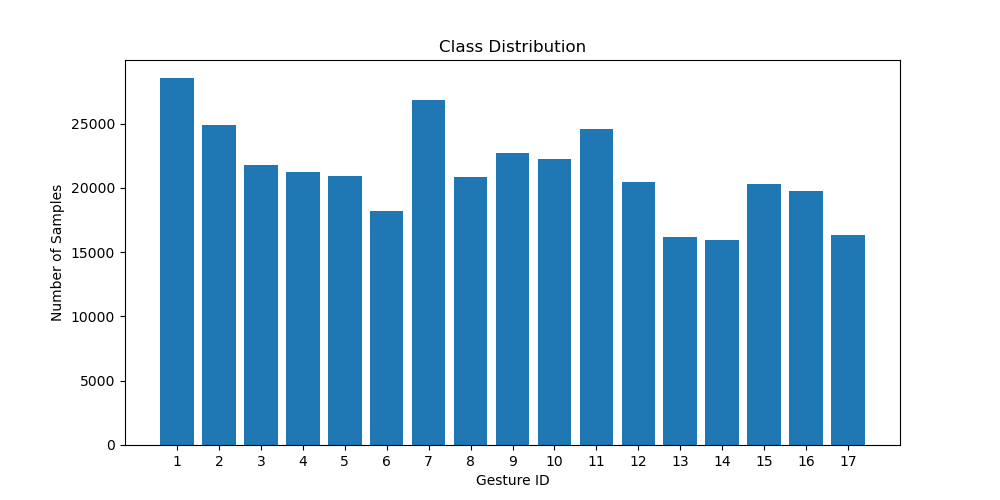

In [6]:
# Class counts
(unique, counts) = np.unique(y[y>0], return_counts=True)
class_counts = dict(zip(unique, counts))
# print("Class counts:", class_counts)
# Plot class distribution as a bar chart
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(list(class_counts.keys()))
plt.xlabel("Gesture ID")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

### Split data for train, test, validation based on subject id

In [7]:
from utils.ml_helpers import set_seeds
set_seeds(42)

In [8]:
# Remove rest class (0)
rest_class = 0
select_class_mask = (y != rest_class)
X = X[select_class_mask]
y = y[select_class_mask]
subject_ids = subject_ids[select_class_mask]
rep_ids = rep_ids[select_class_mask]

In [9]:
# splot data for train, test, validation based on subject id
train_percent = 0.7
test_percent = 0.15
val_percent = 0.15

unique_subjects = np.unique(subject_ids)
n_subjects = len(unique_subjects)

n_train = int(n_subjects * train_percent)
n_test = int(n_subjects * test_percent)

# shuffle subjects
shuffled_subjects = unique_subjects.copy()
np.random.shuffle(shuffled_subjects)

train_subjects = shuffled_subjects[:n_train]
test_subjects = shuffled_subjects[n_train:n_train+n_test]
val_subjects = shuffled_subjects[n_train+n_test:]
print(f"Train subjects: {train_subjects}")
print(f"Test subjects: {test_subjects}")
print(f"Validation subjects: {val_subjects}")

# Set train, test, val indices
train_indices = np.isin(subject_ids, train_subjects)
test_indices = np.isin(subject_ids, test_subjects)
val_indices = np.isin(subject_ids, val_subjects)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
X_val, y_val = X[val_indices], y[val_indices]


Train subjects: [20 17 16 27  5 13 38 28 40  7 26 10 14 32 35  9 18 25  1 34  6 12  2 30
 22  3 31 37]
Test subjects: [ 4 36 24 33 11 23]
Validation subjects: [19 21  8 15 29 39]


In [10]:
# Normalize data based on training set

# Per-channel normalization
mean_train = np.mean(X_train, axis=(0,2), keepdims=True) # Shape (1, C, 1)
std_train = np.std(X_train, axis=(0,2), keepdims=True)
std_train = np.maximum(std_train, 1e-8)  # Prevent division by zero

X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train
X_val = (X_val - mean_train) / std_train

In [11]:
# Keras expects channels last
X_train = np.transpose(X_train, (0, 2, 1))  # Shape (N, L, C)
X_test = np.transpose(X_test, (0, 2, 1))
X_val = np.transpose(X_val, (0, 2, 1))  # Shape (N, L, C)


In [12]:
# Remap labels to start from 0
if y_train.min() == 1:
    y_train = (y_train - 1).astype(np.int32)
    y_test = (y_test - 1).astype(np.int32)
    y_val = (y_val - 1).astype(np.int32)

In [13]:
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")
L,C, = X_train.shape[1], X_train.shape[2]
print(f"Train shape (channels last): {X_train.shape} | L = {L}, C = {C}")

Number of classes: 17
Train shape (channels last): (249159, 400, 12) | L = 400, C = 12


In [14]:
from utils.ml_helpers import get_device
device = get_device()
print(f"Using device: {device}")

Using device: mps


In [17]:
import tensorflow as tf

In [ ]:
# Create TensorFlow datasets
BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, y, batch_size=BATCH, training=False, AUTOTUNE=AUTOTUNE):

    # Create TensorFlow Dataset
    if y is None:
        # Unlabeled dataset
        dataset = tf.data.Dataset.from_tensor_slices(X)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if training:
        dataset = dataset.shuffle(buffer_size=min(len(X), 10_000), reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)    
    return dataset

In [20]:
ds_train = make_dataset(X_train, y_train, training=True)
ds_test = make_dataset(X_test, y_test, training=False)
ds_val = make_dataset(X_val, y_val, training=False)

In [22]:
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix


def build_cnn_model(L,C,num_classes):


    model = models.Sequential([
        layers.Input(shape=(L, C)),  # Input shape (L, C)
        layers.Conv1D(32, kernel_size=7, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPool1D(pool_size=2),
        layers.Dropout(0.1),

        layers.Conv1D(64, kernel_size=7, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPool1D(pool_size=2),
        layers.Dropout(0.15),

        # a slightly larger receptive field via dilation
        layers.Conv1D(128, kernel_size=5, dilation_rate=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPool1D(pool_size=2),
        layers.Dropout(0.2),

        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [ ]:
# Build the model
model = build_cnn_model(L,C,num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 400, 32)        │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 400, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,809 (303.94 KB)

 Trainable params: 77,361 (302.19 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Callbacks
cbs = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    callbacks.ModelCheckpoint(filepath='cnn_emg_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [ ]:
# Optional: class wights to handle class imbalance
# def compute_class_weights(y):
#     counts = Counter(y.tolist())
#     classes = sorted(counts.keys())
#     n = sum(counts.values())
#     # inverse-frequency weights
#     weights = {c: n / (len(classes) * counts[c]) for c in classes}
#     return weights

# class_weights = compute_class_weights(y_train)
# print("Class weights (train):", class_weights)
# Start WITHOUT class weights (your distribution looked reasonable).
# If later needed:
# from collections import Counter
# counts = Counter(y_train_.tolist())
# n = sum(counts.values()); K = len(counts)
# class_weights = {k: n/(K*counts[k]) for k in counts}
# history = model.fit(ds_train, validation_data=ds_val, epochs=60, callbacks=cbs, class_weight=class_weights)


In [ ]:
# Train the model
history = model.fit(
    ds_train,
    epochs=60,
    validation_data=ds_val,
    callbacks=cbs
)

Epoch 1/60
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4285 - loss: 1.7511

1947/1947 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.4377 - loss: 1.6996 - val_accuracy: 0.2205 - val_loss: 2.8608 - learning_rate: 0.0010
Epoch 2/60
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4630 - loss: 1.6226

1947/1947 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.4628 - loss: 1.6077 - val_accuracy: 0.2260 - val_loss: 3.1114 - learning_rate: 0.0010
Epoch 3/60
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4789 - loss: 1.5743

1947/1947 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.4786 - loss: 1.5601 - val_accuracy: 0.2309 - val_loss: 3.1183 - learning_rate: 0.0010
Epoch 4/60
1946/1947 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4908 - loss: 1.5327

1947/1947 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.4892 - loss: 1.5224 - val_accuracy: 0.2348 - val_loss: 3.1880 - learning_rate: 0.0010
Epoch 5/60
 837/1947 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.5084 - loss: 1.5035

In [ ]:
# Evaluate on test set
test_probs = model.predict(ds_test)
test_preds = np.argmax(test_probs, axis=1)


In [ ]:
test_accuracy = np.mean(test_preds == y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, test_preds, digits=4))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, test_preds)
print(cm)

# Generate classical ML features + DL

In [15]:
# emg_features = emg_td_features(X, zc_thresh=0.02, ssc_thresh=0.02, batch_size=20000, flatten=False) # shape (n_samples, n_channels, n_features)
# features_df = features_to_df(emg_features, y, subject_ids=subject_ids, rep_ids=rep_ids)

In [16]:
# # plot_feature_by_gesture(features_df, feature="RMS", channel=5, figsize=(6, 4))
# # plot_feature_mean_sem(features_df, feature="WL", channel=5, figsize=(6, 4))
# # plot_feature_heatmap(features_df, feature="SSC", figsize=(6, 4))
# # radar_gesture_signature(features_df, channel=5, gestures=[1,6,10,14], figsize=(6, 4))
# pca_features = pca_scatter(emg_features, y, figsize=(6, 4))
# if save_figs:
#     plt.savefig(parentDir / "results/figures/feature_visualizations_PCA.png", dpi=300)